In [2]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.decomposition import PCA
import json
import umap

In [26]:
#features used for each cluster

iv_list=['duels', 
         'duelsWon',
         'defensiveDuels',
         'defensiveDuelsWon', 
         'passes', 
         'successfulPasses', 
         'forwardPasses', 
         'succuessfulForwardPasses', 
         'aerialDuels', 
         'aerialDuelsWon', 
         'defensiveActions', 
         'successfulDefensiveAction', 
         'recoveries',
         'opponentHalfRecoveries',
         'losses', 
         'ownHalfLosses',
         'dangerousOwnHalfLosses',
         'looseBallDuels',
         'looseBallDuelsWon',
         'slidingTackles',
         'successfulSlidingTackles',
         'progressiveRun'
         ]
lb_list=['duels', 
         'duelsWon',
         'defensiveDuels',
         'defensiveDuelsWon', 
         'passes', 
         'successfulPasses', 
         'forwardPasses', 
         'successfulForwardPasses', 
         'crosses', 
         'successfulCrosses',
         'aerialDuels', 
         'aerialDuelsWon', 
         'defensiveActions', 
         'successfulDefensiveAction', 
         'recoveries',
         'opponentHalfRecoveries',
         'losses', 
         'ownHalfLosses',
         'dangerousOwnHalfLosses',
         'looseBallDuels',
         'looseBallDuelsWon',
         'slidingTackles',
         'successfulSlidingTackles',
         'interceptions',
         'progressiveRun',
         'xgAssist'
         ]
midfield_list= ['pressingDuels', 
                'recoveries',
                'opponentHalfRecoveries',
                'defensiveDuels',
                'defensiveDuelsWon', 
                'interceptions',
                'xgAssist',
                'passes',
                'successfulPasses',
                'receivedPass',
                'throughPasses',
                'successfulThroughPasses',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'longPasses',
                'successfulLongPasses',
                'losses',
                'ownHalfLosses',
                'keyPasses',
                'xgShot',
                'touchInBox',
                'offensiveDuels'
]

wing_list=[
          'xgShot',
          'shots',
          'shotsOnTarget',
          'shotAssists',
          'touchInBox',
          'xgAssist',
          'receivedPass',
          'successfulPasses',
          'keyPasses',
          'pressingDuels', 
          'crosses',
          'dribbles',
          'progressiveRun',
          'offensiveDuels',
          'offensiveDuelsWon'

]

striker_list=[
          'xgShot',
          'shots',
          'shotsOnTarget',
          'shotAssists',
          'touchInBox',
          'xgAssist',
          'receivedPass',
          'keyPasses',
          'progressivePasses',
          'losses', 
          'ownHalfLosses',
          'recoveries',
          'opponentHalfRecoveries',
          'goals'
    
]
offmid_list=[   'pressingDuels', 
                'looseBallDuels',
                'looseBallDuelsWon',
                'recoveries',
                'opponentHalfRecoveries',
                'interceptions',
                'passes',
                'successfulPasses',
                'receivedPass',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'keyPasses',
                'xgAssist',
                'xgShot',
                'touchInBox',
                'offensiveDuels',
                'shotsOnTarget'
]

defmid_list=[   'pressingDuels', 
                'recoveries',
                'opponentHalfRecoveries',
                'defensiveDuels',
                'defensiveDuelsWon', 
                'interceptions',
                'passes',
                'successfulPasses',
                'receivedPass',
                'throughPasses',
                'successfulThroughPasses',
                'passesToFinalThird',
                'forwardPasses',
                'successfulForwardPasses',
                'progressiveRun',
                'longPasses',
                'successfulLongPasses',
                'losses',
                'ownHalfLosses',
                'keyPasses',
                'xgAssist'
]


In [27]:
#negative features are multiplied by -1 for the convention
loss_list= [
    'total.losses',
    'total.ownHalfLosses',
    'total.dangerousOwnHalfLosses'
]

In [10]:
pd.set_option('display.max_columns', 5000)

In [28]:
#function returns the player given the wyscout match and player id
def get_player(playerid, matchId):

    path='data/events/'+str(matchId)+'.json'
    with open(path, 'r', encoding='utf-8') as f:
        rd = f.read()
    rd=rd[28:-2]
    obj = json.loads(rd)
    dfw = pd.json_normalize(obj)
    dfw=dfw[dfw['player.id']==playerid]
    return dfw['player.name'].iloc[0]

In [29]:
#function to remove the outliers from the data, l and u are upper resp. lower bound of the data to keep
def remove_outliers(data, l, u,threshold=1.5):
    num_dimensions = data.shape[1]
    mask = np.ones(data.shape[0], dtype=bool)

    for dim in range(num_dimensions):
        q1 = np.percentile(data[:, dim], l)
        q3 = np.percentile(data[:, dim], u)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        mask = np.logical_and(mask, (data[:, dim] >= lower_bound) & (data[:, dim] <= upper_bound))

    cleaned_data = data[mask]
    return cleaned_data

In [30]:
#turns the mean of each cluster into a dataframe
def centroiddf(resdf, meanarray):
    df = pd.DataFrame(columns=resdf.columns)
    for i in range(meanarray.shape[0]):
        df.loc[i]=meanarray[i]

    return df

In [31]:
#drops all irrelevant features and removes the outliers. data is prepared and normalized shifted to use cosine similarity
def preprocessarray(attr_list, file, rem, l, u):
    cluster_attr=[]
    for word in attr_list:
        cluster_attr = cluster_attr+['total.'+word]
    df=pd.read_csv(file)
    dfcalc = df[df.columns[df.columns.isin(cluster_attr)]]
    for w in loss_list:
        if(w in cluster_attr):
            df[w]*=-1
            dfcalc[w]*=-1
    arr=dfcalc.to_numpy()
    print('total points')
    print(arr.shape)
    print()
    if(rem):
        arr=remove_outliers(arr, l, u)
    normarr=arr.copy()
    norms=np.linalg.norm(normarr, axis=1, keepdims=True)
    normarr=normarr/norms
    m=abs(normarr.min())+0.5
    print(m)
    print('after cleanup:', arr.shape)
    print(normarr.shape)
    return normarr+m, arr, df, dfcalc

In [59]:
filename='norm_stats/normalized_defenderstats.csv'
figurename='cbv3.jpg'
poslist=iv_list

remove=True
savefilename='cbv3clustering.csv'
elbowplot=True
n=3

processarray, ogarray, df, dfcalc=preprocessarray(poslist, filename, remove, 15, 85)

total points
(1668, 15)

1.1605671712503747
after cleanup: (1516, 15)
(1516, 15)


c:\Users\Rui\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Rui\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


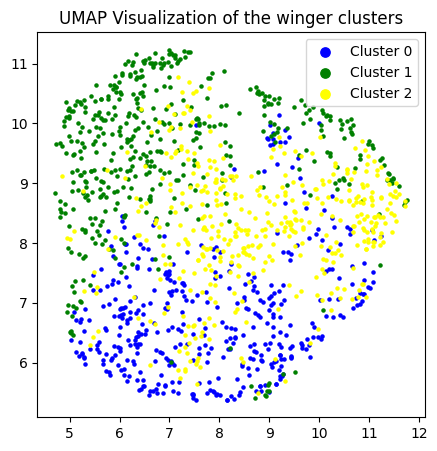

In [58]:
ass=clustering(n, figurename, False, processarray, ogarray)

In [104]:
cluster_lists = [[] for _ in range(n)]
for i, label in enumerate(ass):
    cluster_lists[label].append(i)

meanarr=ogarray.copy()

columnarray=np.empty((0,ogarray.shape[1]))
stdarray=np.empty((0,ogarray.shape[1]))
for i in range(n):

    selected_rows = meanarr[cluster_lists[i], :]
    print('number of points in cluster',i)
    print(len(cluster_lists[i]))

    # Calculate the mean and std every cluster
    column_means = np.mean(selected_rows,axis=0)
    column_std = np.std(selected_rows,axis=0)
    mean_reshaped= column_means.reshape(1,-1)
    std_reshaped = column_std.reshape(1,-1)
    columnarray=np.concatenate((columnarray,mean_reshaped), axis=0)
    stdarray=np.concatenate((stdarray,std_reshaped),axis=0)
    print("Mean of cluster:",i)
    print (column_means)
    print(column_std)

number of points in cluster 0
334
Mean of cluster: 0
[ 0.40652381  0.6372915  -0.27204835 -0.23255981 -0.55371987 -0.4653537
  0.03378759  0.15725809  0.48018601 -0.28127943  0.016407    0.48870648
 -0.32942798  0.61290582]
[0.99007261 0.73928445 0.60763383 0.66580087 0.59369756 0.61924109
 0.77482901 0.76833727 0.73347309 0.41451002 0.75521641 0.84382625
 0.69173232 0.81871782]
number of points in cluster 1
408
Mean of cluster: 1
[-0.32082396 -0.44241883 -0.13150336 -0.07363994  0.68593607  0.49617593
 -0.59910909 -0.62255243 -0.40697508 -0.15920214 -0.04477868 -0.39581304
  0.33785161 -0.4247864 ]
[0.50522371 0.59308726 0.75442377 0.80477096 0.85223352 0.98047234
 0.91723598 0.9602893  0.4466237  0.53183169 0.80710534 0.60198176
 0.94261267 0.54029907]
number of points in cluster 2
369
Mean of cluster: 2
[-0.44147427 -0.50844189 -0.22224459 -0.27437136 -0.40842126 -0.33220795
  0.79588123  0.62521997 -0.43531142 -0.29781629 -0.42589847 -0.42179827
 -0.40698447 -0.48374938]
[0.3049374

In [105]:
meandf=centroiddf(dfcalc,columnarray)
stddf=centroiddf(dfcalc, stdarray)
meandf.to_csv('mean_'+savefilename)
stddf.to_csv('std_'+savefilename)

In [ ]:
pd.read_csv('mean_std/mean_strikerclustering.csv')

In [106]:
meandf

,total.goals,total.shots,total.keyPasses,total.shotAssists,total.recoveries,total.opponentHalfRecoveries,total.losses,total.ownHalfLosses,total.xgShot,total.xgAssist,total.receivedPass,total.touchInBox,total.progressivePasses,total.shotsOnTarget
0,0.406524,0.637292,-0.272048,-0.232560,-0.553720,-0.465354,0.033788,0.157258,0.480186,-0.281279,0.016407,0.488706,-0.329428,0.612906
1,-0.320824,-0.442419,-0.131503,-0.073640,0.685936,0.496176,-0.599109,-0.622552,-0.406975,-0.159202,-0.044779,-0.395813,0.337852,-0.424786
2,-0.441474,-0.508442,-0.222245,-0.274371,-0.408421,-0.332208,0.795881,0.625220,-0.435311,-0.297816,-0.425898,-0.421798,-0.406984,-0.483749
3,0.017723,-0.071204,0.016445,-0.024496,-0.158881,-0.140521,-0.225830,-0.233655,-0.080834,-0.052462,-0.083287,-0.087067,-0.084544,-0.062303


In [107]:
stddf

,total.goals,total.shots,total.keyPasses,total.shotAssists,total.recoveries,total.opponentHalfRecoveries,total.losses,total.ownHalfLosses,total.xgShot,total.xgAssist,total.receivedPass,total.touchInBox,total.progressivePasses,total.shotsOnTarget
0,0.990073,0.739284,0.607634,0.665801,0.593698,0.619241,0.774829,0.768337,0.733473,0.414510,0.755216,0.843826,0.691732,0.818718
1,0.505224,0.593087,0.754424,0.804771,0.852234,0.980472,0.917236,0.960289,0.446624,0.531832,0.807105,0.601982,0.942613,0.540299
2,0.304937,0.550471,0.670278,0.673570,0.659882,0.699150,0.575382,0.479199,0.406112,0.399333,0.674556,0.618228,0.650709,0.496379
3,0.884445,0.989293,0.872601,0.894757,0.844188,0.966413,0.818932,0.916940,0.864530,0.663602,0.960093,1.035281,0.870516,0.939459


In [52]:
#clustering function, using n clusters. elbow is a boolean for printing the elbow plot. arr is a numpy array with the player data and
#normarr is the modified data array, where all performance vectors are divded through their norm.
def clustering(n, figurename, elbow, normarr, arr):
    if(elbow):
        k_values = range(1, 10)

        # Calculate and store the inertia for each k
        inertia_values = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=42)
            cosine_distances = pairwise_distances(normarr, metric='cosine')
            kmeans.fit(cosine_distances)
            inertia_values.append(kmeans.inertia_)

        # Plot the elbow curve
        plt.figure(figsize=(5, 5))
        plt.plot(k_values, inertia_values, marker='o')
        plt.title('Loss per cluster')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.savefig('elbow'+figurename)
        plt.show()
        return []
    else:
        cosine_distances = pairwise_distances(normarr, metric='cosine')
        kmeans= KMeans(n_clusters=n, init="k-means++", random_state=42, max_iter=100000)
        kmeans.fit(cosine_distances)
        # Get the cluster assignments
        cluster_assignments = kmeans.labels_

        # UMAP with the precomputed cosine distances
        umap_embedding = umap.UMAP(n_neighbors=30, metric='precomputed').fit_transform(cosine_distances)
        cluster_colors = ['blue', 'green', 'yellow', 'red']
        # Plot the UMAP embedding with cluster assignments
        plt.figure(figsize=(5, 5))
        for cluster_label in range(n):
            cluster_points = umap_embedding[cluster_assignments == cluster_label]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}', s=5, c=cluster_colors[cluster_label])

        plt.title('UMAP Visualization of the winger clusters')
        plt.legend(markerscale=n) 
        plt.savefig(figurename)
        plt.show()
        return kmeans.labels_